# GRU + Attention (with normalization)

## Overview

**This notebook extends the GRU Classifier model (movie watching) described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)  by adding an `Attention Layer` and normalization**

Attention was first presented by Dzmitry Bahdanau, et al. in their paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).


---
## Data

**Data provided is already preprocessed but needs to be converted in model usabale format**

In [1]:
import torch
import pickle
import numpy as np
import torch.nn as nn

In [2]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


### Dataset organization
`TS` is a dictionary with movie names as keys

Value against each key is a numpy array of dimensions `[#participants, #time points, #ROIs]`

Note that the testretest movie appears on all 4 runs for a participant, therefore the value has dimensions `[#runs, #participants, #time points, #ROIs]`

In [3]:
rel = {}
l = 0
for movie_name, ts in TS.items():
    rel[movie_name] = l
    l += 1
    print(movie_name, ts.shape)

testretest (4, 176, 84, 300)
twomen (176, 245, 300)
bridgeville (176, 222, 300)
pockets (176, 189, 300)
overcome (176, 65, 300)
inception (176, 227, 300)
socialnet (176, 260, 300)
oceans (176, 250, 300)
flower (176, 181, 300)
hotel (176, 186, 300)
garden (176, 205, 300)
dreary (176, 143, 300)
homealone (176, 233, 300)
brokovich (176, 231, 300)
starwars (176, 256, 300)


### Padding sequences

To deal with varying `time points`. For data with `time points < seq_length(self defined)` , I have paded them with 0s. For data with `time points > seq_length(self defined)`, I have split the data into 2 section first, into `[ : seq_length]`, second into `[data_time_point-seq_length : ]`. I have used the `seq_length = 198` (average time_point mentioned in the paper).

**Final `features` array is a 2D array, with shape = `(seq_length,300)`.**

The following block shows above mentioned discussion

In [4]:
train_feature = []
test_feature  = []
train_target  = []
test_target   = []
seq_length    = 198

for movie_name, ts in TS.items():
    pep = 0
    if movie_name != "testretest":
        for i in ts:
            pep += 1
            if (pep <= 100):
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                    
                    k = i[i.shape[0]-seq_length:][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                else:
                    train_feature.append(i)
                    train_target.append(rel[movie_name])

            else:
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                   
                    k = i[i.shape[0]-seq_length:][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                else:
                    test_feature.append(i)
                    test_target.append(rel[movie_name])
        print(pep)
    else:
        for jj in ts:
            pep = 0
            for i in jj:
                pep += 1
                if (pep <= 100):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        train_target.append(rel[movie_name])
                    else:
                        train_feature.append(i)
                        train_target.append(rel[movie_name])

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        test_target.append(rel[movie_name])
                    else:
                        test_feature.append(i)
                        test_target.append(rel[movie_name])
            print(pep)

176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176


### Training, Validation, Test

With the data in required shape, The following shows the split into training, validation, and test sets.

In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())

In [6]:
len(train_data),len(test_data)

(2700, 2052)

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
valid_data  = 0.237
t_train     = len(train_data)
data_no     = list(range(t_train))
np.random.shuffle(data_no)
split_no    = int(np.ceil(valid_data*t_train))
train,valid = data_no[split_no:],data_no[:split_no]

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(valid)

train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size)
test_loader   = DataLoader(test_data, batch_size=batch_size,shuffle = True)

In [8]:
len(valid)

640

In [9]:
len(train_loader),len(valid_loader),len(test_loader)

(65, 20, 65)

In [10]:
iter(train_loader).next()[0].shape

torch.Size([32, 198, 300])

In [11]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Models

### Implementing the `Attention` Model

The following figures shows the idea behind it (normalization layers are not shown)


<img src="attntion1.png" align="center">

In [12]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, seq_len, bias=False, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True
        self.bias       = bias
        self.hidden_dim = hidden_dim
        self.seq_len    = seq_len
        
        weight = torch.zeros(hidden_dim, 1)
        nn.init.kaiming_uniform_(weight)
        
        context = torch.zeros(seq_len,seq_len)
        nn.init.kaiming_uniform_(context)
        
        self.context = nn.Parameter(context)
        self.weight  = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(seq_len))
        
    def forward(self, x,mask=None):

        eij = torch.mm(x.contiguous().view(-1, self.hidden_dim ), self.weight).view(-1,self.seq_len)
        if self.bias:
            eij = eij + self.b    
        eij = torch.tanh(eij)
        
        eij = torch.mm(eij,self.context)
        eij = torch.nn.functional.normalize(eij,p=2.0,dim=0)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        weighted_input = x * torch.unsqueeze(a, -1)
        weighted_input = torch.nn.functional.normalize(weighted_input,p=2.0,dim=0)
        
        return torch.sum(weighted_input, 1)

### `GRU Classifier` Model as described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943) with added normalization layers
<img src="gru.png">

In [13]:
class GRU_RNN(nn.Module):

    def __init__(self, input_dim, output_dim,hidden_dim,n_layers,att=True,drop_prob=0.000006):
        super(GRU_RNN, self).__init__()

        self.output_dim = output_dim
        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.att        = att
        
        self.gru       = nn.GRU(input_dim,hidden_dim,num_layers=n_layers,dropout=drop_prob,batch_first=True)
        self.linear    = nn.Linear(hidden_dim,output_dim)
        if att:
            self.attention = Attention(hidden_dim, 198)
        
        self.dropout   = nn.Dropout(0.3)
        self.func      = nn.Softmax(dim = -1)

    def forward(self, x, hidden,encoder_x=0):
        x,hidden = self.gru(x,hidden)

        if self.att:
            x = self.attention(x)
        else:
            x = x[:, -1, :]
        
        x = torch.nn.functional.normalize(x,dim=0)
        
        x = self.dropout(x)
        x = self.linear(x)
        sig_out = self.func(x)
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## Training

In [14]:
def train(epochs,train_loader,net,valid_loader,optimzer,criterion,att=True):
    val_acc = []
    tr_acc = []
    
    clip = 3 # gradient clipping

    net.to(device)
    net.train()
    
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    
    for e in range(epochs):
        num_correct = 0
        h = net.init_hidden(batch_size)
        train_loss = []
        valid_loss = []
        train_acc  = 0.0
        valid_acc  = 0.0 
        counter = 0
        for inputs, labels in train_loader:
            counter += 1
            if counter == 65:
                continue
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            h = h.data
            net.zero_grad()

            output, h = net(inputs, h) 
            pred = torch.round(output.squeeze()) 
            top_value, top_index = torch.max(pred,1)
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)


            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            train_loss.append(loss.item())
        tr_acc.append(num_correct/(len(train_loader.dataset)))



        acc = 0.0
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        v_c = 0
        for inputs, labels in valid_loader:
            v_c += 1
            #if (v_c == 14):
            #    continue
            val_h = val_h.data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            output, val_h = net(inputs, val_h)
            
            pred = torch.round(output.squeeze()) 
            top_value, top_index = torch.max(pred,1)
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)
            acc = num_correct/(len(train_loader.dataset))
            valid_acc += acc.item()

            val_loss = criterion(output.squeeze(),labels)
            val_losses.append(val_loss.item())
            if val_loss.item() <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss.item()))
                if att:
                    torch.save(net.state_dict(), 'RNN_GRU_Att.pt')
                else:
                    torch.save(net.state_dict(), 'RNN_GRU.pt')
                valid_loss_min = val_loss.item()

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        val_acc.append(valid_acc/len(valid_loader))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    return train_losses,valid_losses,tr_acc,val_acc

In [15]:
epochs     = 55
input_dim  = 300
hidden_dim = 32
output_dim = 15
n_layers   = 2
lr         = 0.006

### Training with Attention Layer

In [16]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=6e-06)
  (linear): Linear(in_features=32, out_features=15, bias=True)
  (attention): Attention()
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [17]:
train_losses,valid_losses,tr_acc,val_acc = train(epochs,train_loader,model,valid_loader,optimizer,criterion)

Validation loss decreased (inf --> 2.485496).  Saving model ...
Validation loss decreased (2.485496 --> 2.477715).  Saving model ...
Validation loss decreased (2.477715 --> 2.439403).  Saving model ...
Epoch: 1/55 	Training Loss: 2.612245 	Validation Loss: 2.523331
Validation loss decreased (2.439403 --> 2.327251).  Saving model ...
Validation loss decreased (2.327251 --> 2.284764).  Saving model ...
Epoch: 2/55 	Training Loss: 2.468560 	Validation Loss: 2.399697
Validation loss decreased (2.284764 --> 2.272093).  Saving model ...
Validation loss decreased (2.272093 --> 2.267678).  Saving model ...
Validation loss decreased (2.267678 --> 2.230921).  Saving model ...
Validation loss decreased (2.230921 --> 2.163292).  Saving model ...
Epoch: 3/55 	Training Loss: 2.331809 	Validation Loss: 2.272173
Validation loss decreased (2.163292 --> 2.086107).  Saving model ...
Validation loss decreased (2.086107 --> 2.079929).  Saving model ...
Epoch: 4/55 	Training Loss: 2.218675 	Validation Loss:

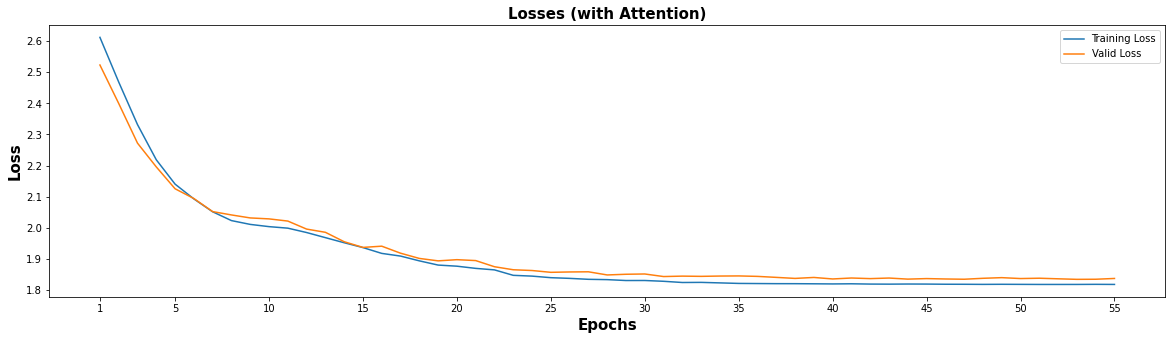

In [18]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
x  = [i for i in range(1,epochs+1)]
xi = [i for i in range(0,epochs+5,5)]
xi[0] = 1
plt.plot(x,train_losses)
plt.plot(x,valid_losses)
plt.xticks(xi)
plt.xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Loss",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.title("Losses (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Loss","Valid Loss"]);

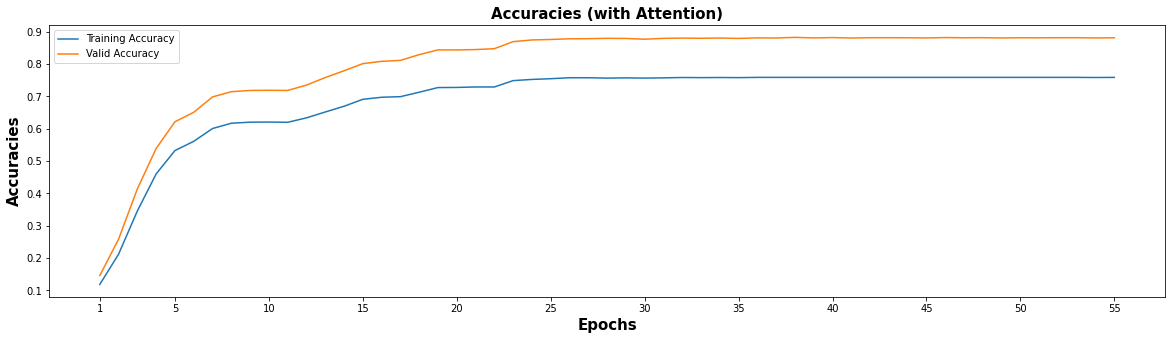

In [19]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(x,tr_acc)
plt.plot(x,val_acc)
plt.xticks(xi)
plt.xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Accuracies",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.title("Accuracies (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Accuracy","Valid Accuracy"]);

### Training without Attention Layer

In [20]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=6e-06)
  (linear): Linear(in_features=32, out_features=15, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [21]:
train_losses_1,valid_losses_1,tr_acc_1,val_acc_1= train(epochs,train_loader,model,valid_loader,optimizer,criterion,att=False)

Validation loss decreased (inf --> 2.576638).  Saving model ...
Validation loss decreased (2.576638 --> 2.545745).  Saving model ...
Validation loss decreased (2.545745 --> 2.494016).  Saving model ...
Validation loss decreased (2.494016 --> 2.484973).  Saving model ...
Epoch: 1/55 	Training Loss: 2.645768 	Validation Loss: 2.563459
Validation loss decreased (2.484973 --> 2.438948).  Saving model ...
Validation loss decreased (2.438948 --> 2.409795).  Saving model ...
Validation loss decreased (2.409795 --> 2.341540).  Saving model ...
Epoch: 2/55 	Training Loss: 2.502964 	Validation Loss: 2.424972
Validation loss decreased (2.341540 --> 2.341492).  Saving model ...
Validation loss decreased (2.341492 --> 2.255080).  Saving model ...
Epoch: 3/55 	Training Loss: 2.379825 	Validation Loss: 2.369869
Validation loss decreased (2.255080 --> 2.173104).  Saving model ...
Validation loss decreased (2.173104 --> 2.162851).  Saving model ...
Epoch: 4/55 	Training Loss: 2.312107 	Validation Loss:

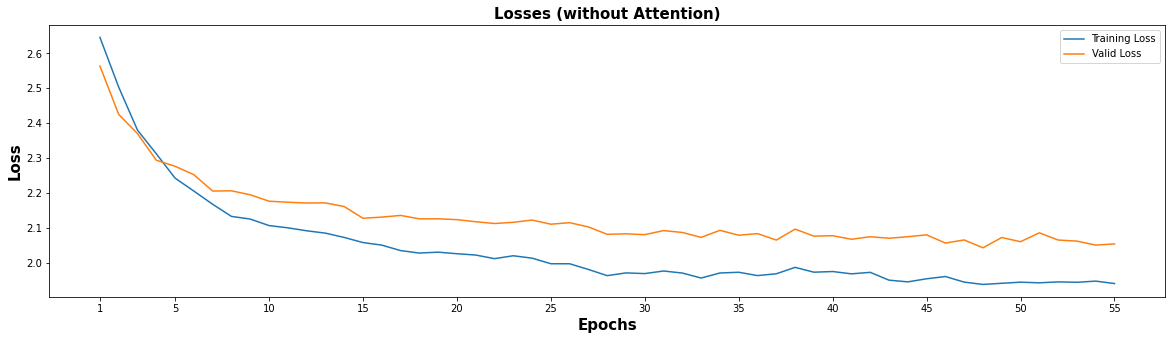

In [22]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(x,train_losses_1)
plt.plot(x,valid_losses_1)
plt.xticks(xi)
plt.xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Loss",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.title("Losses (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Loss","Valid Loss"]);

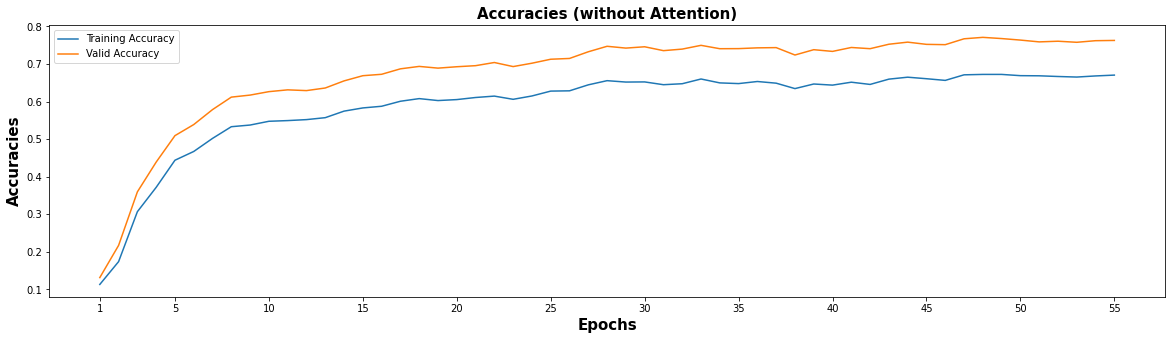

In [23]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot([i for i in range(1,epochs+1)],tr_acc_1)
plt.plot([i for i in range(1,epochs+1)],val_acc_1)
plt.xticks(xi)
plt.xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Accuracies",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.title("Accuracies (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Accuracy","Valid Accuracy"]);

## Testing

In [24]:
def test(test_loader,net):
    v_c = 0
    net.eval()
    net.to(device)
    num_correct = 0
    valid_acc = 0
    h = net.init_hidden(batch_size)
    for inputs, labels in test_loader:
        v_c += 1
        if (v_c == 65):
            continue
        h = h.data
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

        output, h = net(inputs, h)

        pred = torch.round(output.squeeze()) 
        top_value, top_index = torch.max(pred,1)
        correct_tensor = top_index.eq(labels.float().view_as(top_index))
        correct = np.squeeze(correct_tensor.to('cpu').numpy())
        num_correct += np.sum(correct)
    
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

### Accuracy with Attention Layer

In [26]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
model.load_state_dict(torch.load('RNN_GRU_Att.pt'))

<All keys matched successfully>

In [27]:
test(test_loader,model)

Test accuracy: 0.969


### Accuracy without Attention Layer

In [28]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
model.load_state_dict(torch.load('RNN_GRU.pt'))

<All keys matched successfully>

In [29]:
test(test_loader,model)

Test accuracy: 0.782


## Conclusion

Adding an Attention Layer has increased the model accuracy as expected.
The model furthur can be extended/improved by using other methods such as `transformers`